In [1]:
import numpy as np
import pandas as pd
from typing import Mapping, List, Tuple
from collections import defaultdict
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import load_boston, load_iris, load_wine, load_digits, \
    load_breast_cancer, load_diabetes, fetch_mldata
from  matplotlib.collections import LineCollection
import time
from pandas.api.types import is_string_dtype, is_object_dtype, is_categorical_dtype, is_bool_dtype
from sklearn.ensemble.partial_dependence import partial_dependence, plot_partial_dependence
from pdpbox import pdp
from rfpimp import *
from scipy.integrate import cumtrapz
from stratx.partdep import *
from stratx.ice import *
from dtreeviz.trees import *


%config InlineBackend.figure_formats = ['svg','png']

from stratx.support import *

In [2]:
X, y = load_rent(n=10_000)

Rent has 49352 records


In [3]:
np.unique(X['bathrooms'], return_counts=True)

(array([0. , 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. ]),
 array([  57, 8183,  135, 1505,   34,   72,    2,   12]))

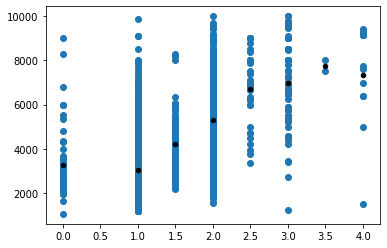

In [4]:
plt.scatter(X['bathrooms'],y)
df = pd.concat([X,y], axis=1)
avg_per_baths = df.groupby('bathrooms').mean()['price']
plt.scatter(np.unique(X['bathrooms']), avg_per_baths, s=20, c='black')
plt.show()

In [5]:
X, y = load_bulldozer(n=20_000)
df = pd.concat([X,y], axis=1)

Loading cached version...


In [6]:
df.describe()

,ModelID,datasource,YearMade,auctioneerID,MachineHours,age,AC,ProductSize,MachineHours_na,saleyear,salemonth,saleday,saledayofweek,saledayofyear,SalePrice
count,20000.0000,20000.000000,20000.000000,20000.000000,20000.00000,20000.000000,20000.00000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.00000
mean,8711.7102,146.095050,1999.698750,6.956000,4462.86245,10.950350,0.38810,1.424600,0.492900,2010.649100,7.184850,17.002300,2.371950,204.311800,33405.65725
std,7705.3986,15.445509,7.509682,20.170774,6955.09305,7.522188,0.48733,1.697191,0.499962,0.477264,3.252708,8.421736,1.213827,98.047702,24647.97121
min,28.0000,121.000000,1953.000000,0.000000,4.00000,0.000000,0.00000,0.000000,0.000000,2010.000000,1.000000,1.000000,0.000000,6.000000,4750.00000
25%,3356.0000,132.000000,1997.000000,1.000000,3138.00000,6.000000,0.00000,0.000000,0.000000,2010.000000,5.000000,10.000000,1.000000,134.000000,15000.00000
50%,4701.0000,149.000000,2002.000000,1.000000,3138.00000,8.000000,0.00000,0.000000,0.000000,2011.000000,7.000000,17.000000,2.000000,208.000000,26000.00000
75%,14272.0000,149.000000,2005.000000,3.000000,4329.00000,14.000000,1.00000,3.000000,1.000000,2011.000000,10.000000,24.000000,3.000000,280.000000,45000.00000
max,36879.0000,172.000000,2011.000000,99.000000,821747.00000,58.000000,1.00000,5.000000,1.000000,2011.000000,12.000000,31.000000,6.000000,364.000000,141000.00000


In [7]:
np.nanmean(X['MachineHours']), np.nanmedian(X['MachineHours'])

(4462.86245, 3138.0)

In [8]:
np.mean(X[X['MachineHours_na']==0]['YearMade']), np.mean(X[X['MachineHours_na']==1]['YearMade'])

(2000.9061329126405, 1998.456583485494)

In [9]:
np.median(df[X['MachineHours_na']==0]['SalePrice']), np.median(df[X['MachineHours_na']==1]['SalePrice'])

(27000.0, 24000.0)

In [10]:
X['YearMade'].mean()

1999.69875

In [11]:
sum(X['MachineHours_na']==1), len(X)

(9858, 20000)

In [12]:
X[X['MachineHours_na']==0].describe()

,ModelID,datasource,YearMade,auctioneerID,MachineHours,age,AC,ProductSize,MachineHours_na,saleyear,salemonth,saleday,saledayofweek,saledayofyear
count,10142.000000,10142.000000,10142.000000,10142.000000,10142.000000,10142.000000,10142.000000,10142.000000,10142.0,10142.000000,10142.000000,10142.000000,10142.000000,10142.000000
mean,9286.562118,148.181029,2000.906133,5.674916,5750.625616,9.725597,0.452080,1.492999,0.0,2010.631729,7.152041,16.820154,2.326267,203.107375
std,8021.078624,19.156628,6.015287,18.181413,9593.327523,6.053743,0.497723,1.710568,0.0,0.482359,3.266483,8.338916,1.184048,98.425455
min,28.000000,121.000000,1959.000000,0.000000,4.000000,0.000000,0.000000,0.000000,0.0,2010.000000,1.000000,1.000000,0.000000,6.000000
25%,3261.000000,132.000000,1998.000000,1.000000,2206.000000,5.000000,0.000000,0.000000,0.0,2010.000000,4.000000,10.000000,1.000000,119.000000
50%,4794.000000,149.000000,2003.000000,1.000000,4262.500000,8.000000,0.000000,0.000000,0.0,2011.000000,7.000000,16.000000,2.000000,207.000000
75%,15261.000000,172.000000,2005.000000,3.000000,7542.500000,13.000000,1.000000,3.000000,0.0,2011.000000,10.000000,24.000000,3.000000,285.000000
max,36879.000000,172.000000,2011.000000,99.000000,821747.000000,52.000000,1.000000,5.000000,0.0,2011.000000,12.000000,31.000000,6.000000,363.000000


In [13]:
X[X['MachineHours_na']==1].describe()

,ModelID,datasource,YearMade,auctioneerID,MachineHours,age,AC,ProductSize,MachineHours_na,saleyear,salemonth,saleday,saledayofweek,saledayofyear
count,9858.000000,9858.000000,9858.000000,9858.000000,9858.0,9858.000000,9858.000000,9858.000000,9858.0,9858.000000,9858.000000,9858.000000,9858.000000,9858.000000
mean,8120.297322,143.948975,1998.456583,8.273991,3138.0,12.210388,0.322276,1.354230,1.0,2010.666971,7.218604,17.189694,2.418949,205.550923
std,7319.959297,9.868751,8.611154,21.953817,0.0,8.600448,0.467372,1.680502,0.0,0.471321,3.238294,8.502453,1.242028,97.647028
min,28.000000,121.000000,1953.000000,0.000000,3138.0,0.000000,0.000000,0.000000,1.0,2010.000000,1.000000,1.000000,0.000000,6.000000
25%,3357.000000,132.000000,1996.000000,1.000000,3138.0,6.000000,0.000000,0.000000,1.0,2010.000000,5.000000,10.000000,1.000000,145.000000
50%,4639.000000,149.000000,2001.000000,1.000000,3138.0,9.000000,0.000000,0.000000,1.0,2011.000000,7.000000,17.000000,2.000000,208.000000
75%,12917.000000,149.000000,2005.000000,3.000000,3138.0,15.000000,1.000000,3.000000,1.0,2011.000000,10.000000,25.000000,3.000000,279.000000
max,36877.000000,172.000000,2011.000000,99.000000,3138.0,58.000000,1.000000,5.000000,1.0,2011.000000,12.000000,31.000000,6.000000,364.000000


In [14]:
hours = X[X['MachineHours']!=3138]['MachineHours']
hours

356257    8657.0
356813    2307.0
376561    3498.0
387603    9531.0
373314    4846.0
           ...  
376333    4690.0
383370    5470.0
371888    9231.0
364140    4666.0
382815    7161.0
Name: MachineHours, Length: 10141, dtype: float64

In [15]:
hours = hours.clip(0,25000)

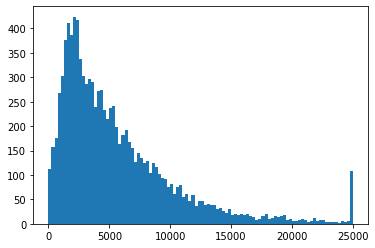

In [16]:
plt.hist(hours.astype(int), bins=100)
plt.show()

In [17]:
ux, cx = np.unique(hours.astype(int).values, return_counts=True)

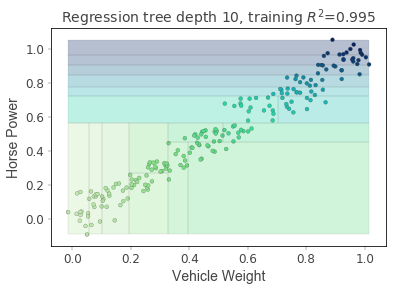

In [18]:
x = np.random.uniform(0,1,size=200)
x1 = x + np.random.normal(0,0.05,200)
x2 = x + np.random.normal(0,0.05,200)
X = np.vstack([x1,x2]).T

y = X[:,0] + X[:,1]**2

fig, ax = plt.subplots(1, 1)
t = rtreeviz_bivar_heatmap(ax,
                           X, y,
#                           max_depth=4,
                           min_samples_leaf=10,
                           feature_names=['Vehicle Weight', 'Horse Power'],
                           fontsize=14)
plt.show()

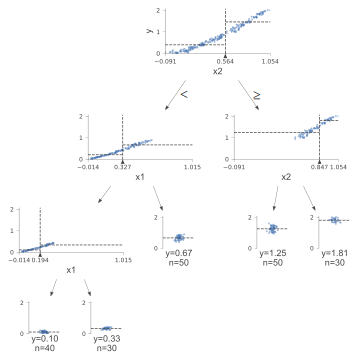

In [26]:
regr = tree.DecisionTreeRegressor(min_samples_leaf=30)  # limit depth of tree
regr.fit(X, y)
dtreeviz(regr,
               X, 
               y,
               target_name='y', 
               feature_names=['x1','x2'])